In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
%cd gdrive/MyDrive/Colab Notebooks/CITS5553

/content/gdrive/MyDrive/Colab Notebooks/CITS5553


In [8]:
import pandas as pd
import numpy as np, warnings
from pathlib import Path
import os
import sys
# import sweetviz as sv
from importlib import reload
import matplotlib.pyplot as plt

np.warnings = warnings

ROOT_DIR = Path('')
sys.path.append(os.path.abspath(os.path.join('../Kha Huynh/Data cleansing')))
sys.path.append(os.path.abspath(os.path.join('..')))
# import DataLoader as DataLoader
# reload(DataLoader)

# dataLoader = DataLoader.DataLoader(ROOT_DIR)

import model_evaluation as me
reload(me)

# import src.modelling_pipeline as modelling_pipeline
# reload(modelling_pipeline)

# mp = modelling_pipeline.ModelPipeline(ROOT_DIR)

<module 'model_evaluation' from '/content/gdrive/MyDrive/Colab Notebooks/CITS5553/model_evaluation.py'>

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# evaluation metrics
from tensorflow.keras.utils import to_categorical
from keras.utils import to_categorical

import tensorflow as tf

# Data Preparation - Train val test split

In [9]:
# t0_df = pd.read_csv(df_final)
path_df = ROOT_DIR / 'data/Model input data/t4_nan.csv'
df_data = pd.read_csv(path_df)# t0_df

admission = df_data[['SUBJECT_ID', 'HADM_ID', 'IS_SEPSIS']].drop_duplicates(["SUBJECT_ID", "HADM_ID"])

def df_split(X, Y, test_size):
    x_train, x_test, y_train, y_test = train_test_split(
        X,  # dropping the target column for X values
        Y,
        test_size=test_size,  # this means 20% test set
        stratify=Y,  # stratify by the target variable
        random_state=42  # to ensure reproducibility
        )
    return x_train, x_test, y_train, y_test

def create_data_df(data_df):
    x_train_df = df_data.merge(data_df[['SUBJECT_ID', 'HADM_ID']])
    x_train_df['count'] = x_train_df.groupby(['SUBJECT_ID', 'HADM_ID'])['HADM_ID'].transform('count')
    x_train_count = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['count']
    y_train_df = x_train_df.drop_duplicates(['SUBJECT_ID', 'HADM_ID'])['IS_SEPSIS']
    return x_train_df, x_train_count, y_train_df

x_train_df, x_test_df, y_train_df, _ = df_split(admission.drop('IS_SEPSIS', axis=1),  # dropping the target column for X values
                                                admission['IS_SEPSIS'],
                                                test_size=0.2,
                                                )

x_train_df, x_train_count, y_train_df = create_data_df(x_train_df)
x_test_df, x_test_count, y_test_df = create_data_df(x_test_df)

In [10]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median', missing_values=np.nan)

train_gendernum = x_train_df.GENDER_NUM.values #take out the column doesn't need to scale
test_gendernum = x_test_df.GENDER_NUM.values

# impute X
x_train = imputer.fit_transform(x_train_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))
x_test = imputer.transform(x_test_df.drop(["SUBJECT_ID", "HADM_ID", 'IS_SEPSIS', 'CHARTTIME', 'count', 'GENDER_NUM'], axis=1))

In [11]:
# Feature scaling - Standardisation
scaler = StandardScaler()

x_train = scaler.fit_transform(x_train) #scale X
x_test = scaler.transform(x_test)

x_train = np.column_stack((x_train, train_gendernum)) #merge the columns doesn't need to scale back to X
x_test = np.column_stack((x_test, test_gendernum))

In [12]:
def ts_to_secs(X, X_count, Y):
    secs_data = tf.RaggedTensor.from_row_lengths(X, X_count)
    mask = tf.math.is_finite(secs_data.values)
    mask = tf.RaggedTensor.from_row_lengths(mask, X_count)

    # act_secs_labels = Y.values
    # act_secs_labels = np.array(act_secs_labels)
    act_secs_labels = to_categorical(Y)
    return secs_data, act_secs_labels, mask


In [13]:
def data_preparation():
  train_data, act_train, mask_train = ts_to_secs(x_train, x_train_count, y_train_df)
  test_data, act_test, mask_test = ts_to_secs(x_test, x_test_count, y_test_df)

  # Here we add an extra dimension to the datasets just to be ready for using with Convolution2D
  print("[INFO] -- Shape of Training Sections:")
  print(train_data.bounding_shape())
  print("[INFO] -- Shape of Test Sections:")
  print(test_data.bounding_shape())

  return train_data, act_train, test_data, act_test

In [14]:
x_train, y_train, x_test, y_test = data_preparation()

[INFO] -- Shape of Training Sections:
tf.Tensor([36972    13    43], shape=(3,), dtype=int64)
[INFO] -- Shape of Test Sections:
tf.Tensor([9244   13   43], shape=(3,), dtype=int64)


# Model Definition

In [15]:
import model_evaluation as me
reload(me)

me.get_class_weights(y_train_df)

# sample_weights = mask_train
sample_weights = me.compute_sample_weights(y_train[:,1].astype(int))
# sample_weights = compute_sample_weights(y_train.astype(int))

# sample_weights_test = mask_test
sample_weights_test = me.compute_sample_weights(y_test[:,1].astype(int))
# sample_weights_test = compute_sample_weights(y_test.astype(int))

In [16]:
import keras

METRICS = [
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.AUC(name='auc'),
]

m_hist = []
models = []

# Simple LSTM

In [17]:
from keras.optimizers import schedules
from keras.callbacks import LearningRateScheduler
import math

init_lr = 0.001

def scheduler(epoch):
  return init_lr * tf.math.exp(-0.1 * epoch)
lr_scheduler = LearningRateScheduler(scheduler)

In [18]:
from keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import LSTM, Input, GRU, Masking
from keras.models import Sequential, Model
from sklearn.model_selection import  train_test_split
import time
import keras
import numpy as np
from keras.models import Sequential

def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(128))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = LSTM_model()
models.append(model)

In [19]:
def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(256))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = LSTM_model()
models.append(model)

In [20]:
def LSTM_model():
    feat_no = x_train[0][0].shape[0]
    d = 0.25
    model=Sequential()
    model.add(Input(shape=[None, feat_no], dtype=tf.float32, ragged=True))
    model.add(LSTM(64))
    model.add(Dropout(0.5))
    model.add(Dense(2, activation='sigmoid'))

    return model
model = LSTM_model()
models.append(model)

In [21]:
from sklearn.model_selection import StratifiedKFold
k = 5
fold_size = x_train.shape[0] // k
num_epochs = 40

skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
for i, model in enumerate(models):
  print(f"----------------Start model {i}---------------------")

  checkpointer = ModelCheckpoint(filepath = f'weights_best_struct_lstm1_{i}.hdf5', save_best_only = True, monitor='val_accuracy', mode='max')
  early_stop = keras.callbacks.EarlyStopping(monitor = 'val_accuracy', mode = 'max', patience=5, restore_best_weights=True)
  callbacks_list = [lr_scheduler, early_stop, checkpointer]
  model.summary()
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=init_lr), loss='binary_crossentropy', metrics = METRICS)
  acc, val_acc, auc, val_auc, loss, val_loss= [], [], [], [], [], []
  # Loop through the k folds
  for j, (train_index, val_index) in enumerate(skf.split(x_train, y_train.argmax(1))):
    print(f'---------------------Start K={j}-------------------------------')

    x_train_kf, x_val_kf = tf.gather(x_train, train_index), tf.gather(x_train, val_index)
    y_train_kf, y_val_kf = y_train[train_index], y_train[val_index]

    sample_weights = me.compute_sample_weights(y_train_kf[:,1].astype(int))

    # Train the model
    m = model.fit(x_train_kf,y_train_kf,
              sample_weight=sample_weights,
              epochs=num_epochs, batch_size=64, verbose=1,
              validation_data=(x_val_kf, y_val_kf),
              callbacks=callbacks_list)
    m_hist.append(m)

----------------Start model 0---------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               88064     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 2)                 258       
                                                                 
Total params: 88322 (345.01 KB)
Trainable params: 88322 (345.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
---------------------Start K=0-------------------------------
Epoch 1/40
463/463 [==============================] - 16s 13ms/step - loss: 0.5578 - accuracy: 0.7121 - auc: 0.7576 - val_loss: 0.5548 - val_accuracy: 0.7425 - val_auc: 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
463/463 [==============================] - 4s 8ms/step - loss: 0.5064 - accuracy: 0.7639 - auc: 0.8223 - val_loss: 0.5268 - val_accuracy: 0.7560 - val_auc: 0.8164 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4926 - accuracy: 0.7674 - auc: 0.8334 - val_loss: 0.5151 - val_accuracy: 0.7535 - val_auc: 0.8234 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 8ms/step - loss: 0.4793 - accuracy: 0.7737 - auc: 0.8437 - val_loss: 0.4954 - val_accuracy: 0.7686 - val_auc: 0.8407 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 3s 7ms/step - loss: 0.4687 - accuracy: 0.7810 - auc: 0.8533 - val_loss: 0.4748 - val_accuracy: 0.7836 - val_auc: 0.8550 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4575 - accuracy: 0.7870 - auc: 0.8608 - val_loss: 0.4905 - val_accuracy: 0.7708 - val_auc: 0.8440 - lr: 6.0653e-04
Epoch 7/40
463/463 [=========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 8ms/step - loss: 0.4175 - accuracy: 0.8116 - auc: 0.8891 - val_loss: 0.4106 - val_accuracy: 0.8158 - val_auc: 0.8930 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 4s 8ms/step - loss: 0.4022 - accuracy: 0.8195 - auc: 0.8950 - val_loss: 0.4056 - val_accuracy: 0.8176 - val_auc: 0.8958 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 8ms/step - loss: 0.3834 - accuracy: 0.8307 - auc: 0.9066 - val_loss: 0.3998 - val_accuracy: 0.8238 - val_auc: 0.8996 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 3s 7ms/step - loss: 0.3768 - accuracy: 0.8343 - auc: 0.9106 - val_loss: 0.4019 - val_accuracy: 0.8221 - val_auc: 0.8987 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3648 - accuracy: 0.8400 - auc: 0.9154 - val_loss: 0.3895 - val_accuracy: 0.8308 - val_auc: 0.9062 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 4

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 8ms/step - loss: 0.3422 - accuracy: 0.8518 - auc: 0.9254 - val_loss: 0.3157 - val_accuracy: 0.8699 - val_auc: 0.9390 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 4s 9ms/step - loss: 0.3304 - accuracy: 0.8589 - auc: 0.9323 - val_loss: 0.3230 - val_accuracy: 0.8588 - val_auc: 0.9356 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 8ms/step - loss: 0.3075 - accuracy: 0.8663 - auc: 0.9381 - val_loss: 0.2890 - val_accuracy: 0.8791 - val_auc: 0.9488 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 8ms/step - loss: 0.2937 - accuracy: 0.8758 - auc: 0.9456 - val_loss: 0.2931 - val_accuracy: 0.8771 - val_auc: 0.9471 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 9ms/step - loss: 0.2813 - accuracy: 0.8828 - auc: 0.9501 - val_loss: 0.3006 - val_accuracy: 0.8753 - val_auc: 0.9445 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 4s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 3s 7ms/step - loss: 0.2892 - accuracy: 0.8763 - auc: 0.9476 - val_loss: 0.2777 - val_accuracy: 0.8814 - val_auc: 0.9531 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 8ms/step - loss: 0.2753 - accuracy: 0.8873 - auc: 0.9538 - val_loss: 0.2815 - val_accuracy: 0.8821 - val_auc: 0.9520 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 8ms/step - loss: 0.2643 - accuracy: 0.8908 - auc: 0.9568 - val_loss: 0.2946 - val_accuracy: 0.8760 - val_auc: 0.9475 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 3s 7ms/step - loss: 0.2534 - accuracy: 0.8972 - auc: 0.9606 - val_loss: 0.2947 - val_accuracy: 0.8789 - val_auc: 0.9477 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 4s 8ms/step - loss: 0.2527 - accuracy: 0.8985 - auc: 0.9620 - val_loss: 0.3014 - val_accuracy: 0.8771 - val_auc: 0.9466 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 4s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 8ms/step - loss: 0.3284 - accuracy: 0.8581 - auc: 0.9306 - val_loss: 0.2445 - val_accuracy: 0.9067 - val_auc: 0.9665 - lr: 0.0010
Epoch 2/40
463/463 [==============================] - 4s 8ms/step - loss: 0.2851 - accuracy: 0.8798 - auc: 0.9489 - val_loss: 0.2487 - val_accuracy: 0.8992 - val_auc: 0.9636 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 4s 8ms/step - loss: 0.2741 - accuracy: 0.8901 - auc: 0.9555 - val_loss: 0.2567 - val_accuracy: 0.8939 - val_auc: 0.9602 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 3s 7ms/step - loss: 0.2562 - accuracy: 0.8950 - auc: 0.9593 - val_loss: 0.2464 - val_accuracy: 0.9001 - val_auc: 0.9638 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 3s 7ms/step - loss: 0.2446 - accuracy: 0.9008 - auc: 0.9640 - val_loss: 0.2422 - val_accuracy: 0.9001 - val_auc: 0.9647 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 5s 10m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 7ms/step - loss: 0.5072 - accuracy: 0.7638 - auc: 0.8239 - val_loss: 0.5463 - val_accuracy: 0.7335 - val_auc: 0.7973 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 4s 8ms/step - loss: 0.4901 - accuracy: 0.7651 - auc: 0.8357 - val_loss: 0.5030 - val_accuracy: 0.7696 - val_auc: 0.8362 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4760 - accuracy: 0.7741 - auc: 0.8472 - val_loss: 0.4948 - val_accuracy: 0.7688 - val_auc: 0.8401 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4629 - accuracy: 0.7819 - auc: 0.8573 - val_loss: 0.4995 - val_accuracy: 0.7619 - val_auc: 0.8367 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4481 - accuracy: 0.7863 - auc: 0.8647 - val_loss: 0.4622 - val_accuracy: 0.7897 - val_auc: 0.8637 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 4s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 3/40
463/463 [==============================] - 3s 7ms/step - loss: 0.3667 - accuracy: 0.8384 - auc: 0.9152 - val_loss: 0.3669 - val_accuracy: 0.8402 - val_auc: 0.9159 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 9ms/step - loss: 0.3439 - accuracy: 0.8503 - auc: 0.9249 - val_loss: 0.3360 - val_accuracy: 0.8526 - val_auc: 0.9298 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 8ms/step - loss: 0.3300 - accuracy: 0.8612 - auc: 0.9344 - val_loss: 0.3653 - val_accuracy: 0.8401 - val_auc: 0.9179 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 8ms/step - loss: 0.3120 - accuracy: 0.8658 - auc: 0.9390 - val_loss: 0.3565 - val_accuracy: 0.8517 - val_auc: 0.9227 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 4s 9ms/step - loss: 0.3004 - accuracy: 0.8737 - auc: 0.9451 - val_loss: 0.3561 - val_accuracy: 0.8498 - val_auc: 0.9229 - lr: 5.4881e-04
Epoch 8/40
463/463 [=========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 3s 7ms/step - loss: 0.2647 - accuracy: 0.8890 - auc: 0.9574 - val_loss: 0.2436 - val_accuracy: 0.9015 - val_auc: 0.9651 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 9ms/step - loss: 0.2450 - accuracy: 0.8992 - auc: 0.9642 - val_loss: 0.2416 - val_accuracy: 0.9018 - val_auc: 0.9650 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 8ms/step - loss: 0.2342 - accuracy: 0.9076 - auc: 0.9682 - val_loss: 0.2562 - val_accuracy: 0.8946 - val_auc: 0.9601 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 8ms/step - loss: 0.2224 - accuracy: 0.9083 - auc: 0.9706 - val_loss: 0.2494 - val_accuracy: 0.9030 - val_auc: 0.9625 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 4s 8ms/step - loss: 0.2099 - accuracy: 0.9178 - auc: 0.9752 - val_loss: 0.2454 - val_accuracy: 0.9002 - val_auc: 0.9633 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 4s

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 5s 10ms/step - loss: 0.2096 - accuracy: 0.9161 - auc: 0.9748 - val_loss: 0.1879 - val_accuracy: 0.9290 - val_auc: 0.9803 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 8ms/step - loss: 0.1928 - accuracy: 0.9231 - auc: 0.9784 - val_loss: 0.1763 - val_accuracy: 0.9349 - val_auc: 0.9821 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 3s 7ms/step - loss: 0.1784 - accuracy: 0.9331 - auc: 0.9831 - val_loss: 0.1936 - val_accuracy: 0.9272 - val_auc: 0.9783 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 8ms/step - loss: 0.1698 - accuracy: 0.9347 - auc: 0.9842 - val_loss: 0.1772 - val_accuracy: 0.9323 - val_auc: 0.9819 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 3s 7ms/step - loss: 0.1688 - accuracy: 0.9348 - auc: 0.9845 - val_loss: 0.1918 - val_accuracy: 0.9303 - val_auc: 0.9784 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 4

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 5s 11ms/step - loss: 0.1711 - accuracy: 0.9360 - auc: 0.9841 - val_loss: 0.1580 - val_accuracy: 0.9395 - val_auc: 0.9855 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 7ms/step - loss: 0.1597 - accuracy: 0.9407 - auc: 0.9866 - val_loss: 0.1602 - val_accuracy: 0.9377 - val_auc: 0.9850 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 9ms/step - loss: 0.1519 - accuracy: 0.9438 - auc: 0.9876 - val_loss: 0.1851 - val_accuracy: 0.9303 - val_auc: 0.9793 - lr: 6.0653e-04
Epoch 7/40
463/463 [==============================] - 4s 7ms/step - loss: 0.1487 - accuracy: 0.9442 - auc: 0.9879 - val_loss: 0.1627 - val_accuracy: 0.9375 - val_auc: 0.9839 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 3s 7ms/step - loss: 0.1428 - accuracy: 0.9481 - auc: 0.9893 - val_loss: 0.1609 - val_accuracy: 0.9385 - val_auc: 0.9847 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 4

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/40
463/463 [==============================] - 3s 7ms/step - loss: 0.5147 - accuracy: 0.7579 - auc: 0.8155 - val_loss: 0.5411 - val_accuracy: 0.7522 - val_auc: 0.8083 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4987 - accuracy: 0.7661 - auc: 0.8291 - val_loss: 0.4842 - val_accuracy: 0.7846 - val_auc: 0.8503 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 8ms/step - loss: 0.4865 - accuracy: 0.7781 - auc: 0.8467 - val_loss: 0.5097 - val_accuracy: 0.7670 - val_auc: 0.8302 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 3s 7ms/step - loss: 0.4775 - accuracy: 0.7766 - auc: 0.8463 - val_loss: 0.5023 - val_accuracy: 0.7707 - val_auc: 0.8358 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 8ms/step - loss: 0.4704 - accuracy: 0.7837 - auc: 0.8553 - val_loss: 0.4841 - val_accuracy: 0.7844 - val_auc: 0.8494 - lr: 6.0653e-04
Epoch 7/40
463/463 [=========================

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 8ms/step - loss: 0.4644 - accuracy: 0.7874 - auc: 0.8618 - val_loss: 0.4209 - val_accuracy: 0.8162 - val_auc: 0.8888 - lr: 0.0010
Epoch 2/40
463/463 [==============================] - 4s 9ms/step - loss: 0.4394 - accuracy: 0.8019 - auc: 0.8759 - val_loss: 0.4182 - val_accuracy: 0.8128 - val_auc: 0.8903 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 3s 7ms/step - loss: 0.4298 - accuracy: 0.8074 - auc: 0.8821 - val_loss: 0.4314 - val_accuracy: 0.8082 - val_auc: 0.8823 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 8ms/step - loss: 0.4218 - accuracy: 0.8106 - auc: 0.8863 - val_loss: 0.4231 - val_accuracy: 0.8170 - val_auc: 0.8875 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 5s 10ms/step - loss: 0.4116 - accuracy: 0.8155 - auc: 0.8916 - val_loss: 0.4112 - val_accuracy: 0.8206 - val_auc: 0.8941 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 9m

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 8ms/step - loss: 0.3685 - accuracy: 0.8385 - auc: 0.9130 - val_loss: 0.3927 - val_accuracy: 0.8330 - val_auc: 0.9042 - lr: 5.4881e-04
Epoch 8/40
463/463 [==============================] - 3s 7ms/step - loss: 0.3597 - accuracy: 0.8412 - auc: 0.9162 - val_loss: 0.4064 - val_accuracy: 0.8279 - val_auc: 0.8986 - lr: 4.9659e-04
Epoch 9/40
463/463 [==============================] - 5s 10ms/step - loss: 0.3549 - accuracy: 0.8477 - auc: 0.9198 - val_loss: 0.3950 - val_accuracy: 0.8312 - val_auc: 0.9044 - lr: 4.4933e-04
Epoch 10/40
463/463 [==============================] - 4s 8ms/step - loss: 0.3527 - accuracy: 0.8459 - auc: 0.9199 - val_loss: 0.3948 - val_accuracy: 0.8362 - val_auc: 0.9047 - lr: 4.0657e-04
Epoch 11/40
463/463 [==============================] - 4s 8ms/step - loss: 0.3453 - accuracy: 0.8519 - auc: 0.9241 - val_loss: 0.3973 - val_accuracy: 0.8320 - val_auc: 0.9033 - lr: 3.6788e-04
Epoch 12/40
463/463 [==============================] 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 4s 7ms/step - loss: 0.3658 - accuracy: 0.8428 - auc: 0.9160 - val_loss: 0.3535 - val_accuracy: 0.8466 - val_auc: 0.9226 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 3s 7ms/step - loss: 0.3509 - accuracy: 0.8480 - auc: 0.9220 - val_loss: 0.3469 - val_accuracy: 0.8526 - val_auc: 0.9258 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 8ms/step - loss: 0.3446 - accuracy: 0.8540 - auc: 0.9247 - val_loss: 0.4160 - val_accuracy: 0.8232 - val_auc: 0.8959 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 3s 7ms/step - loss: 0.3365 - accuracy: 0.8524 - auc: 0.9254 - val_loss: 0.3344 - val_accuracy: 0.8576 - val_auc: 0.9311 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 3s 7ms/step - loss: 0.3266 - accuracy: 0.8615 - auc: 0.9334 - val_loss: 0.3824 - val_accuracy: 0.8341 - val_auc: 0.9105 - lr: 6.0653e-04
---------------------Start K=4--------------------------

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


463/463 [==============================] - 5s 10ms/step - loss: 0.3708 - accuracy: 0.8373 - auc: 0.9124 - val_loss: 0.3297 - val_accuracy: 0.8614 - val_auc: 0.9335 - lr: 0.0010
Epoch 2/40
463/463 [==============================] - 3s 7ms/step - loss: 0.3536 - accuracy: 0.8466 - auc: 0.9200 - val_loss: 0.3413 - val_accuracy: 0.8552 - val_auc: 0.9282 - lr: 9.0484e-04
Epoch 3/40
463/463 [==============================] - 4s 7ms/step - loss: 0.3466 - accuracy: 0.8497 - auc: 0.9230 - val_loss: 0.3396 - val_accuracy: 0.8563 - val_auc: 0.9292 - lr: 8.1873e-04
Epoch 4/40
463/463 [==============================] - 4s 9ms/step - loss: 0.3366 - accuracy: 0.8558 - auc: 0.9279 - val_loss: 0.3356 - val_accuracy: 0.8606 - val_auc: 0.9310 - lr: 7.4082e-04
Epoch 5/40
463/463 [==============================] - 4s 9ms/step - loss: 0.3262 - accuracy: 0.8609 - auc: 0.9317 - val_loss: 0.3343 - val_accuracy: 0.8604 - val_auc: 0.9316 - lr: 6.7032e-04
Epoch 6/40
463/463 [==============================] - 4s 8m

In [22]:
reload(me)

chart_types = ['accuracy', 'val_accuracy', 'auc', 'val_auc', 'loss', 'val_loss']
mean_history = me.cal_model_mean(m_hist, k, chart_types)

/content/gdrive/MyDrive/Colab Notebooks/CITS5553/model_evaluation.py:199: RuntimeWarning: Mean of empty slice
  mean_measure = np.nanmean(hist_list, axis=0)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1878: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


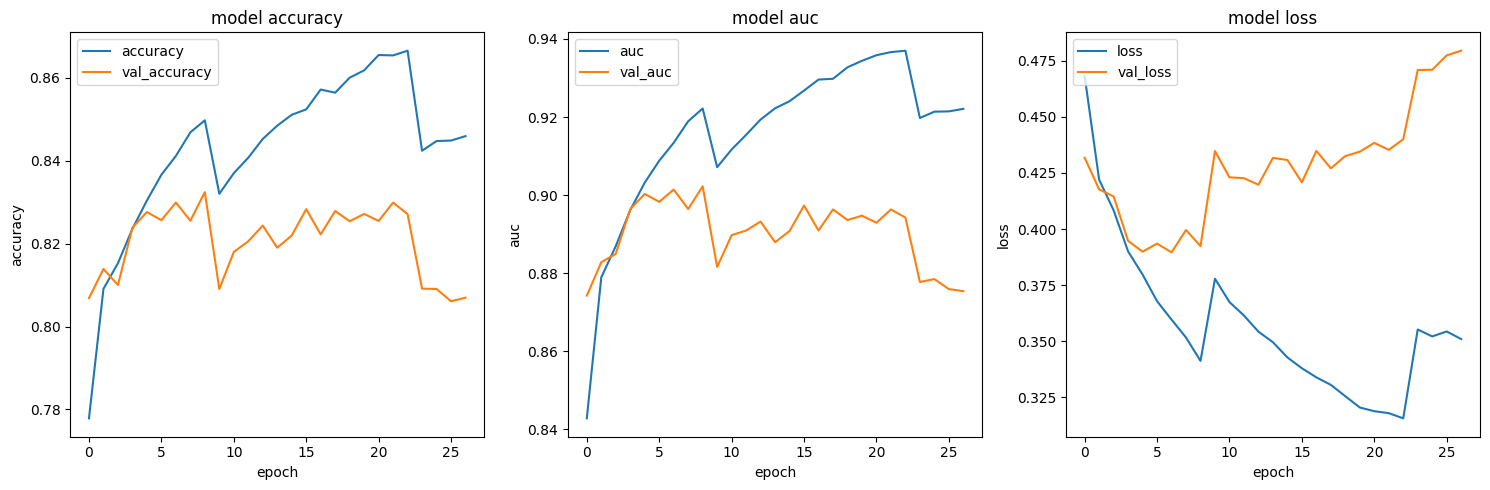

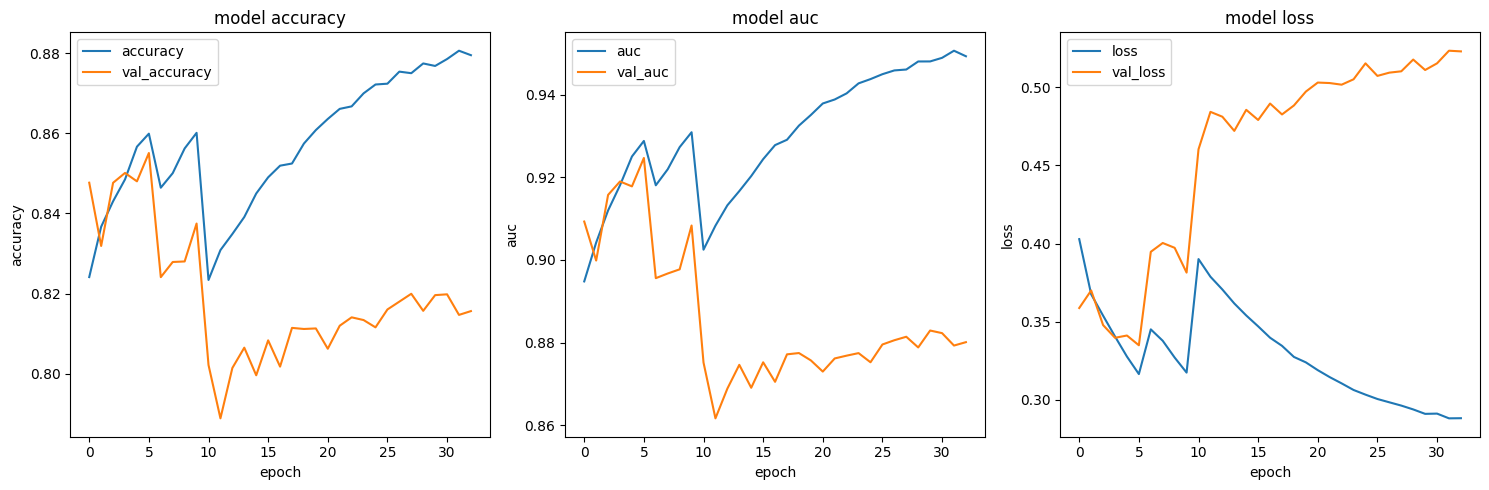

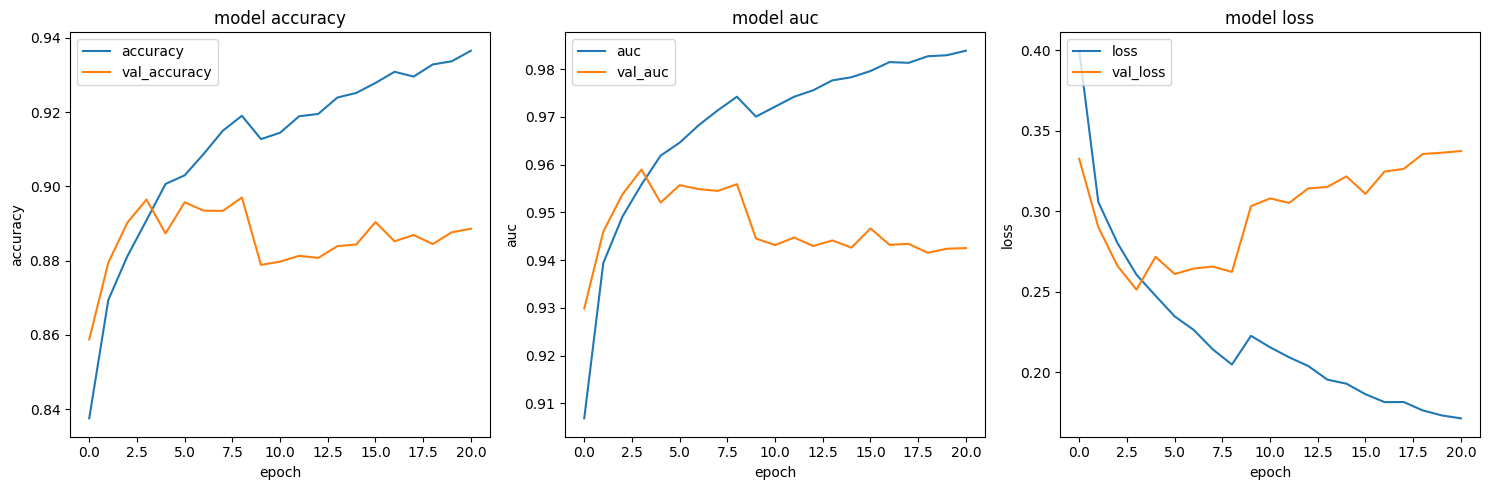

In [23]:
import matplotlib.pyplot as plt

for i, _ in enumerate(mean_history):
  # Create a figure with two subplots side by side
  fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))

  # plt.plot(m.history['loss'])
  plt1.plot(mean_history[i][0])
  plt1.plot(mean_history[i][1])
  plt1.set_title('model accuracy')
  plt1.set_ylabel('accuracy')
  plt1.set_xlabel('epoch')
  plt1.legend(['accuracy', 'val_accuracy'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt2.plot(mean_history[i][2])
  plt2.plot(mean_history[i][3])
  plt2.set_title('model auc')
  plt2.set_ylabel('auc')
  plt2.set_xlabel('epoch')
  plt2.legend(['auc', 'val_auc'], loc='upper left')

  # plt.plot(m.history['loss'])
  plt3.plot(mean_history[i][4])
  plt3.plot(mean_history[i][5])
  plt3.set_title('model loss')
  plt3.set_ylabel('loss')
  plt3.set_xlabel('epoch')
  plt3.legend(['loss', 'val_loss'], loc='upper left')

  plt.tight_layout()
  plt.show()

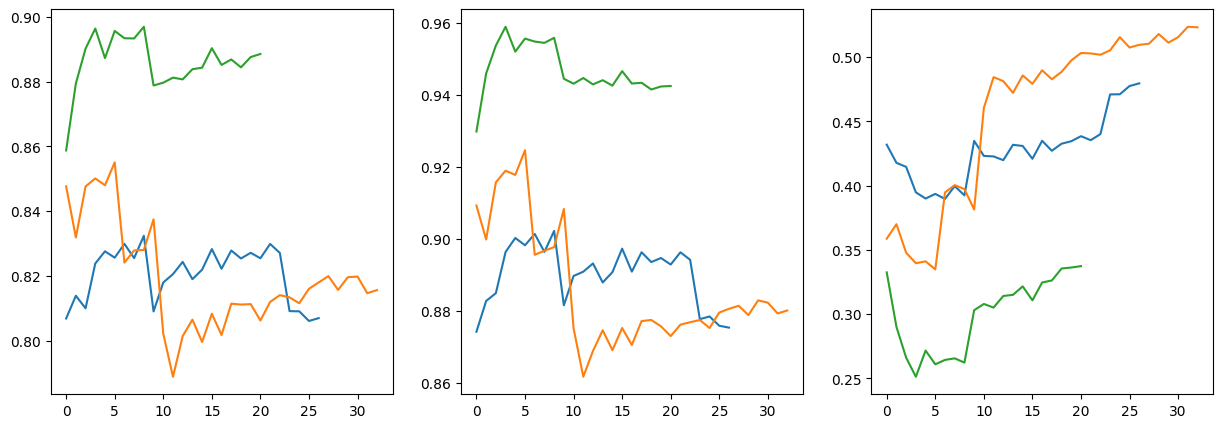

In [24]:
fig, (plt1, plt2, plt3) = plt.subplots(1, 3, figsize=(15, 5))
plts = [plt1, plt2, plt3]

for i, chart in enumerate(range(0, 5, 2)):
  plts[i].plot(mean_history[0][chart+1])
  plts[i].plot(mean_history[1][chart+1])
  plts[i].plot(mean_history[2][chart+1])
  # plts[i].legend([f"lstm softmax val_acc", f"lstm sigmoid val_auc", f"gru softmax val_loss", f"gru sigmoid {chart_type}"], loc="lower right")

Inference:
Inference:
Inference:
289/289 [==============================] - 1s 2ms/step


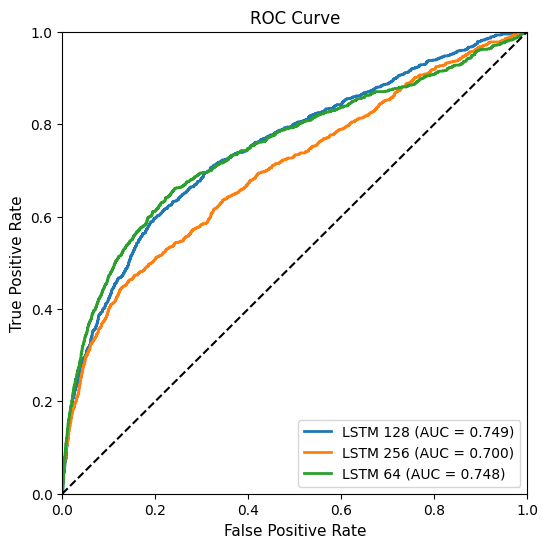

,Model,Balanced acc Train,Balanced acc Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
0,LSTM 128,0.894072,0.682879,0.522771,0.296339,0.885650,0.512563,0.657463,0.375552
1,LSTM 256,0.939651,0.651572,0.721022,0.320919,0.922342,0.407035,0.809351,0.358883
2,LSTM 64,0.870217,0.699330,0.479491,0.313554,0.851973,0.541709,0.613630,0.397200


In [26]:
from keras.models import load_model
reload(me)

trained_models = {}
model_names = ['LSTM 128', 'LSTM 256', 'LSTM 64']
for i, m in enumerate(model_names):
  print("Inference:")
  model = load_model(f"weights_best_struct_lstm1_{i}.hdf5")
  model.optimizer.lr.numpy()
  trained_models[m] = model

me.plot_combined_roc_curves(trained_models, x_train, y_train, x_test, y_test)
# me.print_results(model, x_train, y_train, x_test, y_test)